## Reading HATS: generic parquet readers

This notebook is an attempt at reading HATS catalogs with several parquet readers (Pyarrow, DuckDB and Polars).

In [1]:
small_sky_order1_path = "small_sky_order1"
small_sky_order1_Npix_part_path = "small_sky_order1_Npix_part"
gaia_https_path = "https://data.lsdb.io/unstable/gaia_dr3/gaia"
panstarrs_s3_path = "s3://stpubdata/panstarrs/ps1/public/hipscat/detection"

Let's declare the HATS-specific metadata files to ignore:

In [2]:
ignore_prefixes = ["_common_metadata", "_metadata", "properties", "partition_info.csv", "point_map.fits"]

## PyArrow

Let's start with PyArrow, considering it's the engine behind LSDB.

In [3]:
import pyarrow.parquet as pq
import pyarrow.dataset as pds

In [4]:
# First attempt at reading the catalog fails
dataset = pds.dataset(small_sky_order1_path, format="parquet")
dataset.count_rows()

ArrowInvalid: Could not open Parquet input source 'small_sky_order1/partition_info.csv': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

We need to ignore the non-parquet files from our root directory:

In [5]:
dataset = pds.dataset(
    small_sky_order1_path,
    format="parquet",
    ignore_prefixes=ignore_prefixes,
)
print(dataset.count_rows())
dataset.head(10)

131


pyarrow.Table
id: int64
ra: double
dec: double
ra_error: int64
dec_error: int64
Norder: uint8
Dir: uint64
Npix: uint64
_healpix_29: int64
----
id: [[707,792,811,723,826,750,771,734,738,772]]
ra: [[308.5,320.5,315.5,315.5,335.5,338.5,348.5,348.5,345.5,348.5]]
dec: [[-69.5,-69.5,-68.5,-68.5,-69.5,-67.5,-67.5,-66.5,-64.5,-64.5]]
ra_error: [[0,0,0,0,0,0,0,0,0,0]]
dec_error: [[0,0,0,0,0,0,0,0,0,0]]
Norder: [[1,1,1,1,1,1,1,1,1,1]]
Dir: [[0,0,0,0,0,0,0,0,0,0]]
Npix: [[44,44,44,44,44,44,44,44,44,44]]
_healpix_29: [[3187422220182231470,3187796123455121090,3188300701662669945,3188300701662669945,3192670279995812269,3192995164288065358,3194102393993053262,3195678697494500888,3196676706683767043,3196723640945762243]]

By default the files are not mapped to the correct partitions:

In [6]:
[f for f in dataset.get_fragments()]

[<pyarrow.dataset.ParquetFileFragment path=small_sky_order1/Norder=1/Dir=0/Npix=44.parquet>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/Norder=1/Dir=0/Npix=45.parquet>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/Norder=1/Dir=0/Npix=46.parquet>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/Norder=1/Dir=0/Npix=47.parquet>]

Let's try forcing the hive partitioning:

In [7]:
dataset = pds.dataset(
    small_sky_order1_path,
    format="parquet",
    partitioning="hive",
    ignore_prefixes=ignore_prefixes,
)

ArrowTypeError: Unable to merge: Field Norder has incompatible types: uint8 vs int32

The hive keys are not being correctly cast for the `Norder` field. We need to provide the catalog schema for this to work:

In [8]:
dataset = pds.dataset(
    small_sky_order1_path,
    format="parquet",
    partitioning="hive",
    ignore_prefixes=ignore_prefixes,
    schema=pq.read_metadata(f"{small_sky_order1_path}/_common_metadata").schema.to_arrow_schema(), 
)
print(dataset.count_rows())
dataset.head(10)

131


pyarrow.Table
id: int64
ra: double
dec: double
ra_error: int64
dec_error: int64
Norder: uint8
Dir: uint64
Npix: uint64
_healpix_29: int64
----
id: [[707,792,811,723,826,750,771,734,738,772]]
ra: [[308.5,320.5,315.5,315.5,335.5,338.5,348.5,348.5,345.5,348.5]]
dec: [[-69.5,-69.5,-68.5,-68.5,-69.5,-67.5,-67.5,-66.5,-64.5,-64.5]]
ra_error: [[0,0,0,0,0,0,0,0,0,0]]
dec_error: [[0,0,0,0,0,0,0,0,0,0]]
Norder: [[1,1,1,1,1,1,1,1,1,1]]
Dir: [[0,0,0,0,0,0,0,0,0,0]]
Npix: [[44,44,44,44,44,44,44,44,44,44]]
_healpix_29: [[3187422220182231470,3187796123455121090,3188300701662669945,3188300701662669945,3192670279995812269,3192995164288065358,3194102393993053262,3195678697494500888,3196676706683767043,3196723640945762243]]

In [9]:
[f for f in dataset.get_fragments()]

[<pyarrow.dataset.ParquetFileFragment path=small_sky_order1/Norder=1/Dir=0/Npix=44.parquet partition=[Norder=1, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/Norder=1/Dir=0/Npix=45.parquet partition=[Norder=1, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/Norder=1/Dir=0/Npix=46.parquet partition=[Norder=1, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/Norder=1/Dir=0/Npix=47.parquet partition=[Norder=1, Dir=0]>]

What if we have a sharded `Npix` directory? Should work without any hassle for all readers.

In [10]:
dataset = pds.dataset(
    small_sky_order1_Npix_part_path,
    format="parquet",
    partitioning="hive",
    ignore_prefixes=ignore_prefixes,
    schema=pq.read_metadata(f"{small_sky_order1_Npix_part_path}/_common_metadata").schema.to_arrow_schema(),
)
print(dataset.count_rows())
dataset.head(10)

131


pyarrow.Table
id: int64
ra: double
dec: double
ra_error: int64
dec_error: int64
Norder: uint8
Dir: uint64
Npix: uint64
_healpix_29: int64
----
id: [[707,792,811,723,826,750,771,734,738,772]]
ra: [[308.5,320.5,315.5,315.5,335.5,338.5,348.5,348.5,345.5,348.5]]
dec: [[-69.5,-69.5,-68.5,-68.5,-69.5,-67.5,-67.5,-66.5,-64.5,-64.5]]
ra_error: [[0,0,0,0,0,0,0,0,0,0]]
dec_error: [[0,0,0,0,0,0,0,0,0,0]]
Norder: [[1,1,1,1,1,1,1,1,1,1]]
Dir: [[0,0,0,0,0,0,0,0,0,0]]
Npix: [[44,44,44,44,44,44,44,44,44,44]]
_healpix_29: [[3187422220182231470,3187796123455121090,3188300701662669945,3188300701662669945,3192670279995812269,3192995164288065358,3194102393993053262,3195678697494500888,3196676706683767043,3196723640945762243]]

Now the fragment partitions include information about the respective Npix:

In [11]:
[f for f in dataset.get_fragments()]

[<pyarrow.dataset.ParquetFileFragment path=small_sky_order1_Npix_part/Norder=1/Dir=0/Npix=44/part_0.parquet partition=[Norder=1, Npix=44, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1_Npix_part/Norder=1/Dir=0/Npix=45/part_0.parquet partition=[Norder=1, Npix=45, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1_Npix_part/Norder=1/Dir=0/Npix=46/part_0.parquet partition=[Norder=1, Npix=46, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1_Npix_part/Norder=1/Dir=0/Npix=47/part_0.parquet partition=[Norder=1, Npix=47, Dir=0]>]

Another test we can run is to read catalogs from the cloud (e.g. via HTTPS try to load Gaia on Epyc):

In [12]:
import fsspec

https_fs = fsspec.filesystem('https')

dataset = pds.dataset(
    gaia_https_path,
    format="parquet",
    partitioning="hive",
    # We need to provide a filesystem, otherwise it's not correctly inferred.
    filesystem=https_fs,
    ignore_prefixes=ignore_prefixes,
    schema=pq.read_metadata(f"{gaia_https_path}/_common_metadata", filesystem=https_fs).schema.to_arrow_schema(),
)
print(dataset.count_rows())

ArrowInvalid: Could not open Parquet input source 'https://data.lsdb.io/unstable/gaia_dr3/gaia': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

The `pds.dataset` API doesn't handle remote paths well, but `pds.parquet_dataset` does!

In [13]:
dataset = pds.parquet_dataset(
    metadata_path=f"{gaia_https_path}/_metadata",
    partitioning='hive',
    filesystem=https_fs,
    schema=pq.read_metadata(f"{gaia_https_path}/_common_metadata", filesystem=https_fs).schema.to_arrow_schema()
)

In [14]:
dataset.head(10)

pyarrow.Table
_hipscat_index: uint64
solution_id: int64
designation: string
source_id: int64
random_index: int64
ref_epoch: double
ra: double
ra_error: double
dec: double
dec_error: double
parallax: double
parallax_error: double
parallax_over_error: double
pm: double
pmra: double
pmra_error: double
pmdec: double
pmdec_error: double
ra_dec_corr: double
ra_parallax_corr: double
ra_pmra_corr: double
ra_pmdec_corr: double
dec_parallax_corr: double
dec_pmra_corr: double
dec_pmdec_corr: double
parallax_pmra_corr: double
parallax_pmdec_corr: double
pmra_pmdec_corr: double
astrometric_n_obs_al: int64
astrometric_n_obs_ac: int64
astrometric_n_good_obs_al: int64
astrometric_n_bad_obs_al: int64
astrometric_gof_al: double
astrometric_chi2_al: double
astrometric_excess_noise: double
astrometric_excess_noise_sig: double
astrometric_params_solved: int64
astrometric_primary_flag: bool
nu_eff_used_in_astrometry: double
pseudocolour: double
pseudocolour_error: double
ra_pseudocolour_corr: double
dec_pse

## DuckDB

DuckDB is DB-like API which also allows access to data stored in parquet.

In [15]:
import duckdb

"""
We need to construct a glob pattern to the target parquet files. This seems
to be the only way to avoid non-parquet reads as well; I haven't found a 
solution to ignore prefixes for HATS-specific files at the root.

By default:
- hive_partitioning = true
- hive_types_autocast = true (hive types are automatically detected)
"""
con = duckdb.connect()
query = f"SELECT * FROM read_parquet(['{small_sky_order1_path}/**/*.parquet'])" 
dataset = con.execute(query).df() # Can also we .fetchall() to get Python objects
print(dataset.dtypes)
dataset.head(10)

id               int64
ra             float64
dec            float64
ra_error         int64
dec_error        int64
Norder           int64
Dir              int64
Npix            uint64
_healpix_29      int64
dtype: object


,id,ra,dec,ra_error,dec_error,Norder,Dir,Npix,_healpix_29
0,707,308.5,-69.5,0,0,1,0,44,3187422220182231470
1,792,320.5,-69.5,0,0,1,0,44,3187796123455121090
2,811,315.5,-68.5,0,0,1,0,44,3188300701662669945
3,723,315.5,-68.5,0,0,1,0,44,3188300701662669945
4,826,335.5,-69.5,0,0,1,0,44,3192670279995812269
5,750,338.5,-67.5,0,0,1,0,44,3192995164288065358
6,771,348.5,-67.5,0,0,1,0,44,3194102393993053262
7,734,348.5,-66.5,0,0,1,0,44,3195678697494500888
8,738,345.5,-64.5,0,0,1,0,44,3196676706683767043
9,772,348.5,-64.5,0,0,1,0,44,3196723640945762243


The types for the hive parameters were not inferred correctly (they were autocast to signed int64).

In [16]:
# We should provide a list of paths where the `_common_metadata`, which contains the catalog schema, is present
files = [f'{small_sky_order1_path}/**/*.parquet', f'{small_sky_order1_path}/_common_metadata']
query = f"SELECT * FROM read_parquet({files})" 
dataset = con.execute(query).df()
dataset.dtypes

id               int64
ra             float64
dec            float64
ra_error         int64
dec_error        int64
Norder           uint8
Dir             uint64
Npix            uint64
_healpix_29      int64
dtype: object

In [17]:
# Or we can provide the hive_types manually
query = f"SELECT * FROM read_parquet('{small_sky_order1_path}/**/*.parquet', hive_types = {{'Norder': np.uint64, 'Dir': np.uint64}})" 
dataset = con.execute(query).df()
dataset.dtypes

id               int64
ra             float64
dec            float64
ra_error         int64
dec_error        int64
Norder          uint64
Dir             uint64
Npix            uint64
_healpix_29      int64
dtype: object

If we want to have a look at the data types, we can always just read the schema from the metadata directly:

In [18]:
schema_query = f"SELECT * FROM parquet_schema('{small_sky_order1_path}/_common_metadata')"
schema = con.execute(schema_query).df()
schema

,file_name,name,type,type_length,repetition_type,num_children,converted_type,scale,precision,field_id,logical_type
0,small_sky_order1/_common_metadata,schema,None,None,REQUIRED,9.0,None,NaN,NaN,NaN,None
1,small_sky_order1/_common_metadata,id,INT64,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None
2,small_sky_order1/_common_metadata,ra,DOUBLE,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None
3,small_sky_order1/_common_metadata,dec,DOUBLE,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None
4,small_sky_order1/_common_metadata,ra_error,INT64,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None
5,small_sky_order1/_common_metadata,dec_error,INT64,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None
6,small_sky_order1/_common_metadata,Norder,INT32,None,OPTIONAL,NaN,UINT_8,NaN,NaN,NaN,"IntType(bitWidth=, isSigned=0)"
7,small_sky_order1/_common_metadata,Dir,INT64,None,OPTIONAL,NaN,UINT_64,NaN,NaN,NaN,"IntType(bitWidth=@, isSigned=0)"
8,small_sky_order1/_common_metadata,Npix,INT64,None,OPTIONAL,NaN,UINT_64,NaN,NaN,NaN,"IntType(bitWidth=@, isSigned=0)"
9,small_sky_order1/_common_metadata,_healpix_29,INT64,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None


DuckDB supports filter pushdown which enables selective reading of files according to the hive partition parameters. Filtering on non-hive parameters should still require reading files in their entirety.

```python
# To enable query profiling set the following PRAGMA instructions 
con.execute("PRAGMA enable_profiling = json;")
con.execute("PRAGMA profiling_output = 'query_profile.json';")
```

In [19]:
filter_query = f"SELECT * FROM read_parquet({files}) WHERE ra >= 320 and ra < 330"
con.execute(filter_query).fetchall()

[(792, 320.5, -69.5, 0, 0, 1, 0, 44, 3187796123455121090),
 (733, 329.5, -65.5, 0, 0, 1, 0, 44, 3199487976390127826),
 (804, 322.5, -66.5, 0, 0, 1, 0, 44, 3200256676290451752),
 (747, 327.5, -61.5, 0, 0, 1, 0, 44, 3204516948860795443),
 (730, 322.5, -61.5, 0, 0, 1, 0, 44, 3226002888984791684),
 (758, 325.5, -53.5, 0, 0, 1, 0, 44, 3231100210201107330),
 (780, 326.5, -52.5, 0, 0, 1, 0, 44, 3231184305677168587),
 (775, 321.5, -54.5, 0, 0, 1, 0, 44, 3231700866781904205),
 (760, 320.5, -53.5, 0, 0, 1, 0, 44, 3231878325196547826),
 (787, 320.5, -47.5, 0, 0, 1, 0, 44, 3239635329517312051),
 (762, 327.5, -51.5, 0, 0, 1, 0, 45, 3279291389443808596),
 (728, 328.5, -47.5, 0, 0, 1, 0, 45, 3280519485071506911),
 (704, 326.5, -45.5, 0, 0, 1, 0, 45, 3282636638232395130),
 (724, 323.5, -41.5, 0, 0, 1, 0, 45, 3289601756303010980),
 (808, 320.5, -40.5, 0, 0, 1, 0, 45, 3291070806176264467),
 (761, 329.5, -29.5, 0, 0, 1, 0, 45, 3308757303244427140),
 (796, 320.5, -33.5, 0, 0, 1, 0, 47, 3391463069396352355

Let's try to read a catalog with `Npix` partitioned directories:

In [20]:
# No issues, as expected
files = [f'{small_sky_order1_Npix_part_path}/**/*.parquet', f'{small_sky_order1_Npix_part_path}/_common_metadata']
query = f"SELECT * FROM read_parquet({files})" 
dataset = con.execute(query).df()
dataset

,id,ra,dec,ra_error,dec_error,Norder,Dir,Npix,_healpix_29
0,707,308.5,-69.5,0,0,1,0,44,3187422220182231470
1,792,320.5,-69.5,0,0,1,0,44,3187796123455121090
2,811,315.5,-68.5,0,0,1,0,44,3188300701662669945
3,723,315.5,-68.5,0,0,1,0,44,3188300701662669945
4,826,335.5,-69.5,0,0,1,0,44,3192670279995812269
...,...,...,...,...,...,...,...,...,...
126,791,312.5,-28.5,0,0,1,0,47,3397804200316730633
127,824,305.5,-28.5,0,0,1,0,47,3399000453069933430
128,702,310.5,-27.5,0,0,1,0,47,3399532867186255393
129,767,314.5,-29.5,0,0,1,0,47,3400255793565258227


Unfortunately, DuckDB doesn't seem to support glob patterns for HTTPS URLs!

In [21]:
query = f"SELECT * FROM read_parquet(['{gaia_https_path}/**/*.parquet']) LIMIT 10" 
con.execute(query).df()

HTTPException: HTTP Error: Unable to connect to URL "https://data.lsdb.io/unstable/gaia_dr3/gaia/**/*.parquet": 404 (Not Found)

But it works for accesses on S3, as we can see below:

In [22]:
panstarrs_url = 's3://stpubdata/panstarrs/ps1/public/hipscat/detection'
panstarrs_files = f"['{panstarrs_url}/**/*.parquet', '{panstarrs_url}/_common_metadata']"
panstarrs_query = f"SELECT * FROM read_parquet({panstarrs_files}) LIMIT 10"
panstarrs = con.execute(panstarrs_query).df()
panstarrs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,objID,uniquePspsP2id,detectID,ippObjID,ippDetectID,filterID,surveyID,imageID,randomDetID,dvoRegionID,...,sky,skyErr,infoFlag,infoFlag2,infoFlag3,processingVersion,Norder,Dir,Npix,_hipscat_index
0,65020619473713584,2932801010000368,286948130010000367,524651730043798,367,3,0,81483101,0.987492,122155,...,0.000075,0.000004,35651585,0,3178496,3,2,0,134,9691737277629202432
1,65020619463703650,2932792010000275,286947206010000274,524651730043796,274,3,0,81481701,0.333276,122155,...,0.000075,0.000004,35651585,0,3178496,3,2,0,134,9691737279013322752
2,65020619454443985,2932781010000314,286946282010000313,524651730043793,313,3,0,81480301,0.645818,122155,...,0.000074,0.000004,35651585,0,3178496,3,2,0,134,9691737279390810112
3,65020619457524699,2932776010000302,286945359010000301,524651730043794,301,3,0,81478901,0.192689,122155,...,0.000072,0.000004,35651585,0,3178496,3,2,0,134,9691737279554387968
4,65030619368692391,2932776010000394,286945359010000393,524651730043775,393,3,0,81478901,0.727006,122155,...,0.000076,0.000004,35651585,0,7374912,3,2,0,134,9691737320893448192
5,65030619368692391,2932801010000269,286948130010000268,524651730043775,268,3,0,81483101,0.521557,122155,...,0.000078,0.000004,35651585,0,40929344,3,2,0,134,9691737320906031104
6,65030619368692391,2932792010000350,286947206010000349,524651730043775,349,3,0,81481701,0.634120,122155,...,0.000078,0.000004,35651585,0,7374912,3,2,0,134,9691737320906031105
7,65030619368692391,2932781010000398,286946282010000397,524651730043775,397,3,0,81480301,0.468214,122155,...,0.000076,0.000004,35651585,0,7374912,3,2,0,134,9691737320906031106
8,65030619468286705,2932792010000497,286947206010000496,524651730043797,496,3,0,81481701,0.496314,122155,...,0.000077,0.000004,35651585,0,40929344,3,2,0,134,9691737500703260672
9,65030619468286705,2932781010000428,286946282010000427,524651730043797,427,3,0,81480301,0.411302,122155,...,0.000076,0.000004,35651585,0,7374912,3,2,0,134,9691737500703260673


## Polars

Polars is a very efficient library for data processing in Rust.

In [23]:
import polars as pl

"""
Polars allows for lazy loading with `scan_parquet`.

- We need to construct the glob pattern for parquet (there's no way of ignoring non-parquet files at root);
- We can specify the schema argument as a dictionary.
- We can pass a storage_options dictionary, if needed.
"""
lazy_df = pl.scan_parquet(f"{small_sky_order1_Npix_part_path}/**/*.parquet", hive_partitioning=True)
lazy_df

The schema was correctly inferred without providing any additional metadata!

In [24]:
lazy_df.collect_schema()

Schema([('id', Int64),
        ('ra', Float64),
        ('dec', Float64),
        ('ra_error', Int64),
        ('dec_error', Int64),
        ('Norder', UInt8),
        ('Dir', UInt64),
        ('Npix', UInt64),
        ('_healpix_29', Int64)])

The hive partitioning seems to have been performed correctly as well. Let's attempt to filter on a sharded Npix directory and observe if the lazy plan respect the partitioning.

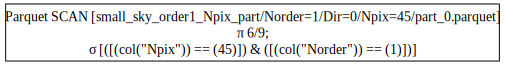

In [25]:
lazy_df_filtered = lazy_df.filter((pl.col('Norder') == 1) & (pl.col('Npix') == 45))
lazy_df_filtered.show_graph()

In [26]:
lazy_df_filtered.collect()

id,ra,dec,ra_error,dec_error,Norder,Dir,Npix,_healpix_29
i64,f64,f64,i64,i64,u8,u64,u64,i64
812,346.5,-60.5,0,0,1,0,45,3245124716102589287
722,350.5,-58.5,0,0,1,0,45,3246262717484375819
731,343.5,-52.5,0,0,1,0,45,3256317681613128823
720,344.5,-47.5,0,0,1,0,45,3257765200567140229
823,338.5,-45.5,0,0,1,0,45,3260117115293246469
…,…,…,…,…,…,…,…,…
705,335.5,-32.5,0,0,1,0,45,3300775760909901001
779,347.5,-29.5,0,0,1,0,45,3302771647141634889
761,329.5,-29.5,0,0,1,0,45,3308757303244427140


We can easily read the parquet schema from the `_common_metadata` directly:

In [27]:
pl.read_parquet_schema(f"{small_sky_order1_Npix_part_path}/_common_metadata")

{'id': Int64,
 'ra': Float64,
 'dec': Float64,
 'ra_error': Int64,
 'dec_error': Int64,
 'Norder': UInt8,
 'Dir': UInt64,
 'Npix': UInt64,
 '_healpix_29': Int64}

Filtering on non-hive partitioning keys works too:

In [28]:
lazy_df_filtered = lazy_df.filter((pl.col("ra") < 320) & (pl.col("dec") > -30))
lazy_df_filtered

In [29]:
lazy_df_filtered.collect()

id,ra,dec,ra_error,dec_error,Norder,Dir,Npix,_healpix_29
i64,f64,f64,i64,i64,u8,u64,u64,i64
770,285.5,-29.5,0,0,1,0,46,3380458994856416389
806,312.5,-29.5,0,0,1,0,47,3397704562975227384
791,312.5,-28.5,0,0,1,0,47,3397804200316730633
824,305.5,-28.5,0,0,1,0,47,3399000453069933430
702,310.5,-27.5,0,0,1,0,47,3399532867186255393
767,314.5,-29.5,0,0,1,0,47,3400255793565258227
743,307.5,-25.5,0,0,1,0,47,3424180623569024089


Polars does not support reading from HTTPS directly, but it's possible through pyarrow.

In [30]:
lazy_df = pl.scan_pyarrow_dataset(
    pds.parquet_dataset(
        metadata_path=f"{gaia_https_path}/_metadata",
        partitioning='hive',
        filesystem=https_fs,
        schema=pq.read_metadata(f"{gaia_https_path}/_common_metadata", filesystem=https_fs).schema.to_arrow_schema()
    )
)
lazy_df.collect_schema()

Schema([('_hipscat_index', UInt64),
        ('solution_id', Int64),
        ('designation', String),
        ('source_id', Int64),
        ('random_index', Int64),
        ('ref_epoch', Float64),
        ('ra', Float64),
        ('ra_error', Float64),
        ('dec', Float64),
        ('dec_error', Float64),
        ('parallax', Float64),
        ('parallax_error', Float64),
        ('parallax_over_error', Float64),
        ('pm', Float64),
        ('pmra', Float64),
        ('pmra_error', Float64),
        ('pmdec', Float64),
        ('pmdec_error', Float64),
        ('ra_dec_corr', Float64),
        ('ra_parallax_corr', Float64),
        ('ra_pmra_corr', Float64),
        ('ra_pmdec_corr', Float64),
        ('dec_parallax_corr', Float64),
        ('dec_pmra_corr', Float64),
        ('dec_pmdec_corr', Float64),
        ('parallax_pmra_corr', Float64),
        ('parallax_pmdec_corr', Float64),
        ('pmra_pmdec_corr', Float64),
        ('astrometric_n_obs_al', Int64),
        ('astr

And we should be able to do the same for S3:

In [31]:
import pyarrow.fs as pafs

s3_fs = pafs.S3FileSystem(anonymous=True)

# Important: This is the s3 URL without the s3:// prefix
panstarrs_bucket = "stpubdata/panstarrs/ps1/public/hipscat/detection"

lazy_df = pl.scan_pyarrow_dataset(
    pds.dataset(
        panstarrs_bucket,
        partitioning="hive",
        filesystem=s3_fs,
        schema=pq.read_metadata(f"{panstarrs_bucket}/_common_metadata", filesystem=s3_fs).schema.to_arrow_schema()
    )
)

In [32]:
lazy_df.collect_schema()

Schema([('objID', Int64),
        ('uniquePspsP2id', Int64),
        ('detectID', Int64),
        ('ippObjID', Int64),
        ('ippDetectID', Int64),
        ('filterID', Int16),
        ('surveyID', Int16),
        ('imageID', Int64),
        ('randomDetID', Float64),
        ('dvoRegionID', Int32),
        ('obsTime', Float64),
        ('xPos', Float64),
        ('yPos', Float64),
        ('xPosErr', Float64),
        ('yPosErr', Float64),
        ('pltScale', Float64),
        ('posAngle', Float64),
        ('ra', Float64),
        ('dec', Float64),
        ('raErr', Float64),
        ('decErr', Float64),
        ('extNSigma', Float64),
        ('zp', Float64),
        ('telluricExt', Float64),
        ('expTime', Float64),
        ('airMass', Float64),
        ('psfFlux', Float64),
        ('psfFluxErr', Float64),
        ('psfMajorFWHM', Float64),
        ('psfMinorFWHM', Float64),
        ('psfTheta', Float64),
        ('psfCore', Float64),
        ('psfQf', Float64),
        ('

In [33]:
lazy_df.head(10).collect()

objID,uniquePspsP2id,detectID,ippObjID,ippDetectID,filterID,surveyID,imageID,randomDetID,dvoRegionID,obsTime,xPos,yPos,xPosErr,yPosErr,pltScale,posAngle,ra,dec,raErr,decErr,extNSigma,zp,telluricExt,expTime,airMass,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfTheta,psfCore,psfQf,psfQfPerfect,psfChiSq,psfLikelihood,momentXX,momentXY,momentYY,momentR1,momentRH,momentM3C,momentM3S,momentM4C,momentM4S,apFlux,apFluxErr,apFillF,apRadius,kronFlux,kronFluxErr,kronRad,sky,skyErr,infoFlag,infoFlag2,infoFlag3,processingVersion,Norder,Dir,Npix,_hipscat_index
i64,i64,i64,i64,i64,i16,i16,i64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i32,i32,i16,u8,u64,u64,u64
65020619473713584,2932801010000368,286948130010000367,524651730043798,367,3,0,81483101,0.987492,122155,56970.48157,3584.04,2403.71,0.166287,0.166287,-0.254889,-124.805,61.947448,-35.813885,0.0423848,0.0423848,14.9532,24.5805,-0.054659,45.0,1.81783,0.00004,0.000003,1.76906,1.62395,48.948898,-0.3042,0.715425,0.715425,1.64999,0.0,0.424329,-0.140196,0.528863,-999.0,1.1308399,0.047567,0.0343857,-0.037027,0.006144,0.000093,0.000001,0.540802,3.56845,-999.0,-999.0,-999.0,0.000075,0.000004,35651585,0,3178496,3,2,0,134,9691737277629202432
65020619463703650,2932792010000275,286947206010000274,524651730043796,274,3,0,81481701,0.333276,122155,56970.472326,3589.23,2397.0,0.160563,0.160563,-0.25492,-124.819,61.946437,-35.813829,0.0409308,0.0409308,13.9516,24.5702,-0.05519,45.0,1.81283,0.000039,0.000003,1.66956,1.60664,28.137501,-0.348813,0.731077,0.731077,1.58138,0.0,0.441084,-0.130206,0.466691,-999.0,1.06585,-0.040252,0.0150122,-0.013074,0.0105999,0.000089,0.000001,0.531144,3.3139701,-999.0,-999.0,-999.0,0.000075,0.000004,35651585,0,3178496,3,2,0,134,9691737279013322752
65020619454443985,2932781010000314,286946282010000313,524651730043793,313,3,0,81480301,0.645818,122155,56970.46309,3593.5,2394.5,0.192573,0.192573,-0.254917,-124.811,61.945524,-35.813548,0.0490903,0.0490903,8.7027197,24.5695,-0.055736,45.0,1.8163,0.000042,0.000004,1.60611,1.53789,33.558498,-0.235916,0.464656,0.464656,1.62357,3.2402e-18,0.439868,-0.109758,0.430126,-999.0,0.977889,-0.023859,0.0137658,-0.02962,0.0105842,0.000085,0.000001,0.519843,3.31393,-999.0,-999.0,-999.0,0.000074,0.000004,35651585,0,3178496,3,2,0,134,9691737279390810112
65020619457524699,2932776010000302,286945359010000301,524651730043794,301,3,0,81478901,0.192689,122155,56970.453866,3586.5,2404.5,0.159087,0.159087,-0.254963,-124.811,61.945826,-35.812968,0.040561,0.040561,12.5168,24.580099,-0.054547,45.0,1.82827,0.000055,0.000004,1.86485,1.52622,41.899799,-0.271882,0.430483,0.430483,1.68627,6.0432e-36,0.46059,-0.094781,0.557522,-999.0,1.10403,-0.045472,0.10141,-0.002502,0.008972,0.000107,0.000001,0.503449,3.5694799,-999.0,-999.0,-999.0,0.000072,0.000004,35651585,0,3178496,3,2,0,134,9691737279554387968
65030619368692391,2932776010000394,286945359010000393,524651730043775,393,3,0,81478901,0.727006,122155,56970.453866,3569.73,2269.3301,0.260379,0.260379,-0.254986,-124.806,61.93693,-35.806557,0.0663931,0.0663931,0.775184,24.5334,-0.054547,45.0,1.82792,0.000023,0.000003,1.8686301,1.5233999,42.800598,-0.237829,0.999026,0.999026,1.03971,0.438231,0.378019,0.056113,0.326448,1.0605201,0.698837,0.040167,0.0274291,0.020412,-0.027581,0.000027,6.0025e-7,0.907833,3.5698099,0.000023,0.000005,2.6513,0.000076,0.000004,35651585,0,7374912,3,2,0,134,9691737320893448192
65030619368692391,2932801010000269,286948130010000268,524651730043775,268,3,0,81483101,0.521557,122155,56970.48157,3565.24,2244.54,0.241055,0.241055,-0.254912,-124.799,61.936927,-35.806393,0.0614479,0.0614479,-2.95542,24.5338,-0.054659,45.0,1.8175,0.000025,0.000003,1.76008,1.61888,49.228802,-0.297489,0.999107,0.999107,1.04617,-0.003122,0.225918,-0.009633,0.278558,0.926795,0.31708,-0.020929,-0.041605,-0.018381,0.002125,0.000014,4.2183e-7,0.906209,3.5687699,0.000016,0.000004,2.3